# Building a mesh file - Marmousi

This tutorial aims to introduce users to mesh generation using `SeismicMesh`. It is a simples 2D mesh.

## 1. SeismicMesh installation

Before actually building the model, the `SeismicMesh` package should be installed. It can be done by cloning the <a href="https://github.com/krober10nd/SeismicMesh">SeismicMesh</a> repository. Once it is cloned, install it by activating `firedrake` environment and running

**<font color='blue'>pip install .</font>**

inside the SeismicMesh folder on your terminal.

## 2. Importing libraries

In [1]:
from scipy.ndimage import gaussian_filter
import numpy as np
import segyio
import matplotlib.pyplot as plt

from mpi4py import MPI
comm = MPI.COMM_WORLD

When building a mesh file, two libraries are essencial:

In [2]:
import meshio
from SeismicMesh import (
    get_sizing_function_from_segy,
    generate_mesh,
    Rectangle,
    write_velocity_model,
    plot_sizing_function,
)

For more details, refer to the <a href="https://seismicmesh.readthedocs.io/en/par3d/tutorial.html#mesh-size-function">SeismicMesh Documentation</a>.

## 3. Velocity model

### 3.a Exact velocity model file

Then, the velocity model file must be imported. Access the <a href="https://wiki.seg.org/wiki/AGL_Elastic_Marmousi">AGL Elastic Marmousi</a> web page and download the `elastic-marmousi-model.tar.gz` compressed file. Extract the files, and access the `models` folder. Extract the velocity model the it is going to be used (`MODEL_P-WAVE_VELOCITY_1.25m.segy`), which was renamed after `vp_marmousi-ii.segy`:

In [3]:
fname = "velocity_models/vp_marmousi-ii.segy"

### 3.b Guess velocity model file

For the guess velocity model file, it is necessary to write a file using `segyio` as follows.

In [4]:
with segyio.open(fname, ignore_geometry=True) as f:
    nz, nx = len(f.samples), len(f.trace)
    vp = np.zeros(shape=(nz, nx))
    for index, trace in enumerate(f.trace):
        vp[:, index] = trace

The original velocity model can be smoothed with a Gaussian filter:

In [5]:
sigma = 100
vp_smooth = gaussian_filter(vp, sigma)

To visualize it, the following commands are useful:

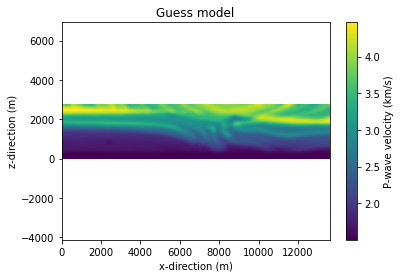

In [6]:
fig, ax = plt.subplots()
plt.pcolormesh(vp_smooth, shading="auto")
plt.title("Guess model")
plt.colorbar(label="P-wave velocity (km/s)")
plt.xlabel("x-direction (m)")
plt.ylabel("z-direction (m)")
ax.axis("equal")
plt.show()

The guess velocity model can be generated as follows:

In [7]:
import h5py

ofname = "marmousi_guess.hdf5"
print(f"Writing velocity model: {ofname}", flush=True)
with h5py.File(ofname, "w") as f:
    f.create_dataset("velocity_model", data=vp_smooth, dtype="f")
    f.attrs["shape"] = vp_smooth.shape
    f.attrs["units"] = "km/s"

Writing velocity model: marmousi_guess.hdf5


## 4. Parameters definition

The next step is defining the arguments for the function `get_sizing_function_from_segy`. First, the boundary coordinates must be defined according to the order

In [8]:
bbox = (-3500.0, 0.0, 0.0, 17000.0)  # min z, min x, max z, max x

and the rectangular domain is created with the function `Rectangle`

In [9]:
rectangle = Rectangle(bbox)

Then, some parameters regarding the wave propagation and the methods used must be informed:
- `fmax`: maximum frequency
- `alpha`: number of cells per wavelength, typically $3<\alpha<10$
- `grade`: rate of change of the element size
- `pad`: the width of the Perfectly Matched Layer (PML) extended domain
- `cmax`: maximum speed of the sound

The parameter `hmin` is associated with the mesh resolution, defined by the expression
$$ h_{min} = \frac{c_{max}}{\alpha f_{max}}$$

In [10]:
hmin = 75.0
alpha = 10
fmax = 2
grade = 0.15
pad = 1e3

Now, all the input parameters are defined and the `get_sizing_function_from_segy` can be raised.

Converting from km-s to m-s...
Mesh sizes will be built to resolve an estimate of wavelength of a 2 hz wavelet with 10 vertices...
Enforcing minimum edge length of 75.0
Enforcing maximum edge length of 10000.0
Enforcing mesh size gradation of 0.15 decimal percent...
Including a 1000.0 meter domain extension...
Using the pad_style: edge


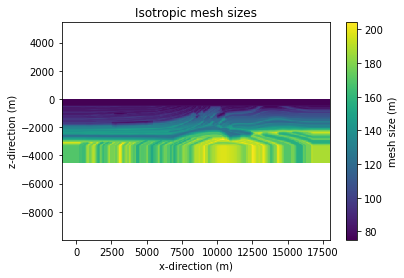

<AxesSubplot:title={'center':'Isotropic mesh sizes'}, xlabel='x-direction (m)', ylabel='z-direction (m)'>

In [15]:
ef = get_sizing_function_from_segy(
    fname,
    bbox,
    hmin=hmin,
    wl=alpha,
    freq=fmax,
    grade=grade,
    domain_pad=pad,
    pad_style="edge",
    units = 'km-s',
)

plot_sizing_function(ef)

## 5. Writing the exact velocity model

In [12]:
write_velocity_model(
    fname,
    ofname="marmousi_exact",
    bbox=bbox,
    domain_pad=pad,
    pad_style="edge",
    units="km-s")

Adding a domain pad to the velocity model...
Including a 1000.0 meter domain extension...
Using the pad_style: edge
Writing velocity model: marmousi_exact.hdf5


To generate the mesh, run

In [13]:
points, cells = generate_mesh(domain=rectangle, edge_length=ef)

Constraining 2 fixed points..
Commencing mesh generation with 6561 vertices on rank 0.
Termination reached...maximum number of iterations reached.
Deleting 1 poor quality boundary entities...


**Note:** `spyro` expects the coordinates to be in kilometers

The mesh can be visualized either with ParaView. It can be done by writing the mesh in a `vtk` format.

**Note:** SeismicMesh output assumes the domain is (z,x) so for visualization in ParaView, the axes must be swapped so it appears as in the (x,z) plane.

In [14]:
if comm.rank == 0:
    meshio.write_points_cells(
        "marmousi.msh",
        points[:, [1, 0]] / 1000,
        [("triangle", cells)],
        file_format="gmsh22",
    )
    meshio.write_points_cells(
        "marmousi.vtk",
        points[:, [1, 0]] / 1000,
        [("triangle", cells)],
        file_format="vtk",
    )